# Data Exploration: Energy Prices and Renewable Generation

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path

# Add project root to path so we can import from src/
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from src.data.synthetic_generator import SyntheticPriceGenerator
from src.data.renewable_generator import WindGenerator, SolarGenerator
from src.data.data_manager import DataManager
from src.config.load_config import get_config
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
print('Imports successful!')

Imports successful!


In [3]:
# Timestamp alignment validation
def validate_and_align_timestamps(*dataframes, reindex_method='forward'):
    """
    Validate that DataFrames have aligned timestamps and frequency.
    If misaligned, reindex to a common timestamp index.
    
    Args:
        *dataframes: Variable number of DataFrames to validate
        reindex_method: How to handle missing values ('forward', 'backward', 'nearest', None)
        
    Returns:
        Tuple of aligned DataFrames
        
    Raises:
        ValueError: If timestamps cannot be aligned
    """
    if len(dataframes) < 2:
        return dataframes
    
    # Get the first DataFrame's index as reference
    ref_df = dataframes[0]
    
    # If multi-index, get the datetime level
    if isinstance(ref_df.index, pd.MultiIndex):
        # Find the datetime index level
        datetime_level = None
        for i, level in enumerate(ref_df.index.levels):
            if isinstance(level, pd.DatetimeIndex):
                datetime_level = i
                break
        if datetime_level is None:
            raise ValueError("No DatetimeIndex found in MultiIndex")
        ref_index = ref_df.index.get_level_values(datetime_level).unique()
    else:
        ref_index = ref_df.index
    
    # Infer frequency
    ref_freq = pd.infer_freq(ref_index)
    
    print(f'=== Timestamp Validation ===')
    print(f'Reference index: {len(ref_index)} timestamps')
    print(f'Inferred frequency: {ref_freq}')
    print(f'Range: {ref_index[0]} to {ref_index[-1]}')
    
    # Validate each DataFrame
    aligned_dfs = [dataframes[0]]
    all_aligned = True
    
    for i, df in enumerate(dataframes[1:], start=1):
        # Get datetime index
        if isinstance(df.index, pd.MultiIndex):
            df_index = df.index.get_level_values(datetime_level).unique()
        else:
            df_index = df.index
        
        df_freq = pd.infer_freq(df_index)
        
        # Check if indices match
        if ref_index.equals(df_index):
            print(f'✓ DataFrame {i}: Aligned ({len(df_index)} timestamps, freq={df_freq})')
            aligned_dfs.append(df)
        else:
            all_aligned = False
            print(f'⚠ DataFrame {i}: Misaligned ({len(df_index)} timestamps, freq={df_freq})')
            
            # Reindex to common index
            if reindex_method:
                print(f'  → Reindexing with method={reindex_method}')
                if isinstance(df.index, pd.MultiIndex):
                    # For MultiIndex, this is more complex - skip for now
                    print(f'  → Skipping reindex for MultiIndex (not implemented)')
                    aligned_dfs.append(df)
                else:
                    aligned_df = df.reindex(ref_index, method=reindex_method)
                    aligned_dfs.append(aligned_df)
            else:
                raise ValueError(f'DataFrame {i} has misaligned timestamps and reindex_method=None')
    
    if all_aligned:
        print('✓ All DataFrames are aligned')
    
    return tuple(aligned_dfs)

print('Timestamp validation utilities loaded')

Timestamp validation utilities loaded


In [4]:
# Multi-scenario helper function
def extract_scenario(df, scenario_id=0, column=None):
    """
    Extract a specific scenario from a DataFrame.
    
    Args:
        df: DataFrame (single or multi-index)
        scenario_id: Which scenario to extract (default 0)
        column: Optional column name to extract
        
    Returns:
        Series or DataFrame for the specified scenario
    """
    if 'scenario_id' in df.index.names:
        # Multi-scenario case: extract using .xs()
        result = df.xs(scenario_id, level='scenario_id')
    else:
        # Single scenario case: use as-is
        result = df
    
    if column and column in result.columns:
        return result[column]
    elif column:
        # Fallback to first column if specified column not found
        return result.iloc[:, 0]
    return result

# Scenario configuration
N_SCENARIOS = 1  # Set to > 1 to generate multiple scenarios
SELECTED_SCENARIO = 0  # Which scenario to analyze

print(f'Scenario configuration: N_SCENARIOS={N_SCENARIOS}, SELECTED_SCENARIO={SELECTED_SCENARIO}')

Scenario configuration: N_SCENARIOS=1, SELECTED_SCENARIO=0


## 2. Load Configuration

In [5]:
config = get_config()
price_gen = SyntheticPriceGenerator(config=config)
wind_gen = WindGenerator(config=config)
solar_gen = SolarGenerator(config=config)
data_manager = DataManager(config=config)
print('Generators initialized')

2025-11-13 07:50:09 - root - INFO - Logging initialized
2025-11-13 07:50:09 - src.data.synthetic_generator - INFO - SyntheticPriceGenerator initialized: kappa=1.2, mu=50.0, sigma=15.0
2025-11-13 07:50:09 - src.data.renewable_generator - INFO - WindGenerator initialized: capacity=100.0MW, CF_mean=0.35, cut_in=3.0m/s
2025-11-13 07:50:09 - src.data.renewable_generator - INFO - SolarGenerator initialized: capacity=100.0MW, CF_mean=0.25, lat=35.0, lon=-120.0
2025-11-13 07:50:09 - src.data.data_manager - INFO - DataManager initialized: raw=data\raw, processed=data\processed, compression=snappy


Generators initialized


In [6]:
price_data = price_gen.generate_price_series('2023-01-01', '2023-12-31', 'H', N_SCENARIOS)
wind_data = wind_gen.generate_wind_profile('2023-01-01', '2023-12-31', 'H', N_SCENARIOS)
solar_data = solar_gen.generate_solar_profile('2023-01-01', '2023-12-31', 'H', N_SCENARIOS)
print(f'Data generated: {N_SCENARIOS} scenario(s)')


2025-11-13 07:50:09 - src.data.synthetic_generator - INFO - Generating price series: 2023-01-01 to 2023-12-31, freq=H, scenarios=1
2025-11-13 07:50:09 - src.data.synthetic_generator - INFO - Generated 8760 price observations across 1 scenario(s)
2025-11-13 07:50:09 - src.data.renewable_generator - INFO - Generating wind profile: start=2023-01-01, end=2023-12-31, freq=H, scenarios=1
2025-11-13 07:50:09 - src.data.renewable_generator - WARNING - Wind capacity factor (0.03%) is unrealistically low. Expected range: 15-50%. Check Weibull parameters, power curve, and intermittency settings.
2025-11-13 07:50:09 - src.data.renewable_generator - INFO - Generated wind profile: 8760 observations, mean CF=0.03%
2025-11-13 07:50:09 - src.data.renewable_generator - INFO - Generating solar profile: start=2023-01-01, end=2023-12-31, freq=H, scenarios=1
2025-11-13 07:50:09 - src.data.renewable_generator - INFO - Generated solar profile: 8760 observations, mean CF=3.20%


Data generated: 1 scenario(s)


prices = extract_scenario(price_data, SELECTED_SCENARIO, 'price')
print(f'Mean: ${prices.mean():.2f}/MWh')
print(f'Std: ${prices.std():.2f}/MWh')
print(f'Min: ${prices.min():.2f}/MWh')
print(f'Max: ${prices.max():.2f}/MWh')

In [7]:
prices = price_data['price'] if 'scenario_id' not in price_data.index.names else price_data.xs(0, level='scenario_id')['price']
print(f'Mean: ${prices.mean():.2f}/MWh')
print(f'Std: ${prices.std():.2f}/MWh')
print(f'Min: ${prices.min():.2f}/MWh')
print(f'Max: ${prices.max():.2f}/MWh')

Mean: $35.06/MWh
Std: $6.49/MWh
Min: $9.53/MWh
Max: $53.52/MWh


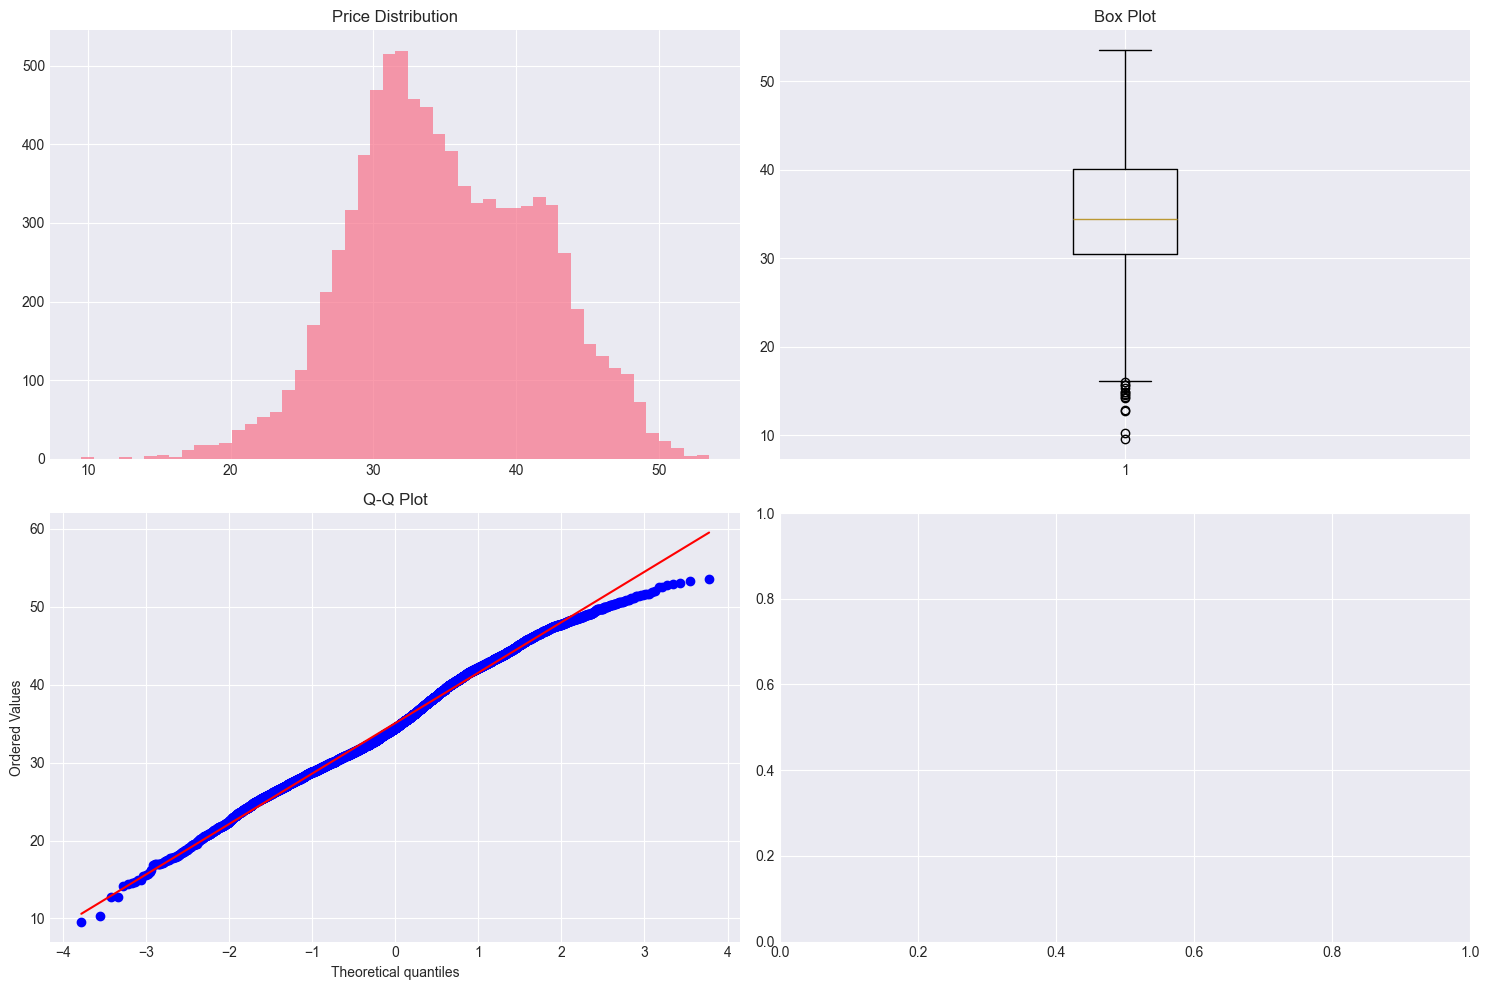

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes[0, 0].hist(prices, bins=50, alpha=0.7)
axes[0, 0].set_title('Price Distribution')
axes[0, 1].boxplot(prices)
axes[0, 1].set_title('Box Plot')
stats.probplot(prices, plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')
plt.tight_layout()
plt.show()

In [9]:
wind_mw = wind_data['generation_mw'] if 'scenario_id' not in wind_data.index.names else wind_data.xs(0, level='scenario_id')['generation_mw']
cf = wind_mw.mean() / wind_gen.capacity_mw
print(f'Wind Capacity Factor: {cf:.1%}')
print(f'Mean: {wind_mw.mean():.2f} MW')

Wind Capacity Factor: 0.0%
Mean: 0.03 MW


In [10]:
solar_mw = extract_scenario(solar_data, SELECTED_SCENARIO, 'generation_mw')
scf = solar_mw.mean() / solar_gen.capacity_mw
print(f'Solar Capacity Factor: {scf:.1%}')
print(f'Mean: {solar_mw.mean():.2f} MW')

Solar Capacity Factor: 3.2%
Mean: 3.20 MW


Validating timestamp alignment before correlation analysis...
=== Timestamp Validation ===
Reference index: 8760 timestamps
Inferred frequency: h
Range: 2023-01-01 00:00:00 to 2023-12-31 23:00:00
✓ DataFrame 1: Aligned (8760 timestamps, freq=h)
✓ DataFrame 2: Aligned (8760 timestamps, freq=h)
✓ All DataFrames are aligned

Correlation Matrix:
          price      wind     solar
price  1.000000 -0.044472 -0.306233
wind  -0.044472  1.000000 -0.013987
solar -0.306233 -0.013987  1.000000


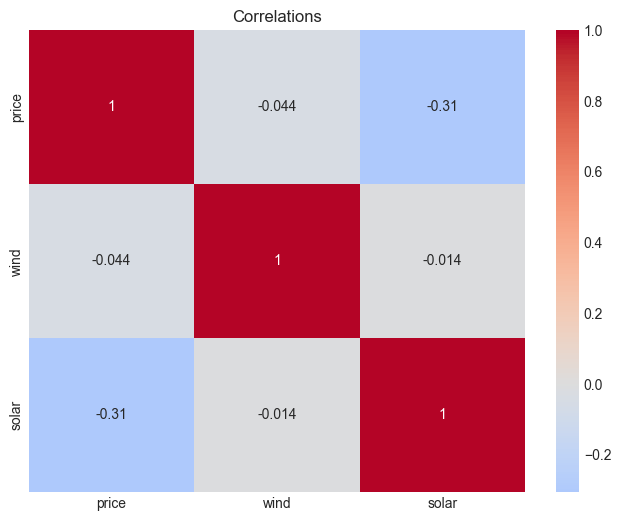

In [11]:
# Validate timestamp alignment before merging
print('Validating timestamp alignment before correlation analysis...')

# Create temporary DataFrames with single columns for validation
price_df = pd.DataFrame({'price': prices})
wind_df = pd.DataFrame({'wind': wind_mw})
solar_df = pd.DataFrame({'solar': solar_mw})

# Validate and align
price_df, wind_df, solar_df = validate_and_align_timestamps(price_df, wind_df, solar_df)

# Now safe to merge
df = pd.DataFrame({
    'price': price_df['price'],
    'wind': wind_df['wind'],
    'solar': solar_df['solar']
})

# Calculate correlations
corr = df.corr()
print('\nCorrelation Matrix:')
print(corr)

# Visualize
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlations')
plt.show()

## 7. Correlation Analysis

Correlation Matrix:
          price      wind     solar
price  1.000000 -0.044472 -0.306233
wind  -0.044472  1.000000 -0.013987
solar -0.306233 -0.013987  1.000000


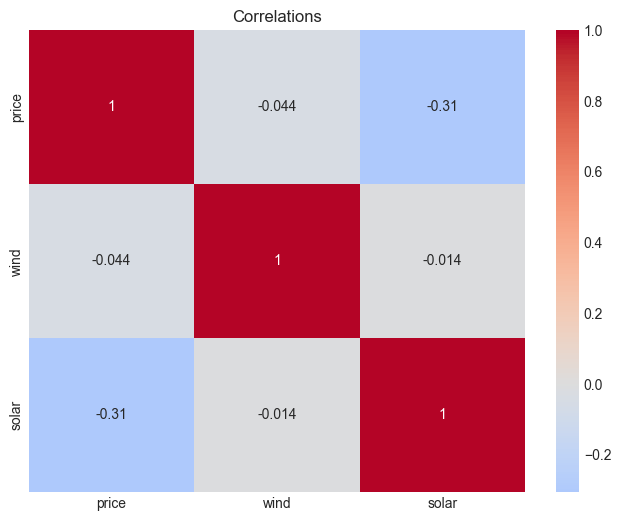

In [12]:
df = pd.DataFrame({'price': prices, 'wind': wind_mw, 'solar': solar_mw})
corr = df.corr()
print('Correlation Matrix:')
print(corr)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlations')
plt.show()

## 8. Summary

In [13]:
print('=== DATA EXPLORATION SUMMARY ===')
print(f'Records: {len(df)}')
print(f'Price Mean: ${prices.mean():.2f}')
print(f'Wind CF: {cf:.1%}')
print(f'Solar CF: {scf:.1%}')
print(f'Price-Wind Corr: {corr.loc["price", "wind"]:.3f}')
print(f'Price-Solar Corr: {corr.loc["price", "solar"]:.3f}')

=== DATA EXPLORATION SUMMARY ===
Records: 8760
Price Mean: $35.06
Wind CF: 0.0%
Solar CF: 3.2%
Price-Wind Corr: -0.044
Price-Solar Corr: -0.306


## 9. Data Persistence

Now we'll save the generated datasets to Parquet storage for use in subsequent notebooks and analyses.

In [14]:
# Save price data
price_path = data_manager.save_processed_data(
    data=price_data,
    source='synthetic',
    dataset='prices',
    start_date='2023-01-01',
    end_date='2023-12-31'
)
print(f'✓ Saved price data to: {price_path}')

# Save wind generation data
wind_path = data_manager.save_processed_data(
    data=wind_data,
    source='synthetic',
    dataset='wind',
    start_date='2023-01-01',
    end_date='2023-12-31'
)
print(f'✓ Saved wind data to: {wind_path}')

# Save solar generation data
solar_path = data_manager.save_processed_data(
    data=solar_data,
    source='synthetic',
    dataset='solar',
    start_date='2023-01-01',
    end_date='2023-12-31'
)
print(f'✓ Saved solar data to: {solar_path}')

2025-11-13 07:50:11 - src.data.data_manager - INFO - Saving processed data: source=synthetic, dataset=prices, rows=8760, start=2023-01-01, end=2023-12-31, format=parquet
2025-11-13 07:50:11 - src.data.data_manager - INFO - Saved 8760 rows to partitioned dataset at data\processed\synthetic_prices_20230101_20231231 (compression=snappy)
2025-11-13 07:50:11 - src.data.data_manager - INFO - Saving processed data: source=synthetic, dataset=wind, rows=8760, start=2023-01-01, end=2023-12-31, format=parquet
2025-11-13 07:50:11 - src.data.data_manager - INFO - Saved 8760 rows to partitioned dataset at data\processed\synthetic_wind_20230101_20231231 (compression=snappy)
2025-11-13 07:50:11 - src.data.data_manager - INFO - Saving processed data: source=synthetic, dataset=solar, rows=8760, start=2023-01-01, end=2023-12-31, format=parquet
2025-11-13 07:50:11 - src.data.data_manager - INFO - Saved 8760 rows to partitioned dataset at data\processed\synthetic_solar_20230101_20231231 (compression=snappy

✓ Saved price data to: data\processed\synthetic_prices_20230101_20231231
✓ Saved wind data to: data\processed\synthetic_wind_20230101_20231231
✓ Saved solar data to: data\processed\synthetic_solar_20230101_20231231


In [15]:
# Verify persistence: reload the saved files and assert equality
print('\n=== Verifying Data Persistence ===')

# Reload price data
reloaded_price = data_manager.load_data(
    source='synthetic',
    dataset='prices',
    data_type='processed',
    start_date='2023-01-01',
    date_filter=True
)
print(f'✓ Reloaded price data: {len(reloaded_price)} rows')

# Reload wind data
reloaded_wind = data_manager.load_data(
    source='synthetic',
    dataset='wind',
    data_type='processed',
    start_date='2023-01-01',
    date_filter=True
)
print(f'✓ Reloaded wind data: {len(reloaded_wind)} rows')

# Reload solar data
reloaded_solar = data_manager.load_data(
    source='synthetic',
    dataset='solar',
    data_type='processed',
    start_date='2023-01-01',
    date_filter=True
)
print(f'✓ Reloaded solar data: {len(reloaded_solar)} rows')

# Verify row counts match
assert len(reloaded_price) == len(price_data), "Price data row count mismatch"
assert len(reloaded_wind) == len(wind_data), "Wind data row count mismatch"
assert len(reloaded_solar) == len(solar_data), "Solar data row count mismatch"

# Verify basic statistics match
price_col = 'price' if 'price' in reloaded_price.columns else reloaded_price.columns[0]
assert np.isclose(reloaded_price[price_col].mean(), prices.mean(), rtol=0.01), "Price mean mismatch"

wind_col = 'generation_mw' if 'generation_mw' in reloaded_wind.columns else reloaded_wind.columns[0]
assert np.isclose(reloaded_wind[wind_col].mean(), wind_mw.mean(), rtol=0.01), "Wind mean mismatch"

solar_col = 'generation_mw' if 'generation_mw' in reloaded_solar.columns else reloaded_solar.columns[0]
assert np.isclose(reloaded_solar[solar_col].mean(), solar_mw.mean(), rtol=0.01), "Solar mean mismatch"

print('✓ All persistence checks passed!')

2025-11-13 07:50:11 - src.data.data_manager - INFO - Loading data: source=synthetic, dataset=prices, type=processed, start=2023-01-01, end=None
2025-11-13 07:50:11 - src.data.data_manager - INFO - Loaded 8760 rows from 1 file(s)
2025-11-13 07:50:11 - src.data.data_manager - INFO - Loading data: source=synthetic, dataset=wind, type=processed, start=2023-01-01, end=None
2025-11-13 07:50:11 - src.data.data_manager - INFO - Loaded 8760 rows from 1 file(s)
2025-11-13 07:50:11 - src.data.data_manager - INFO - Loading data: source=synthetic, dataset=solar, type=processed, start=2023-01-01, end=None



=== Verifying Data Persistence ===
✓ Reloaded price data: 8760 rows
✓ Reloaded wind data: 8760 rows


2025-11-13 07:50:11 - src.data.data_manager - INFO - Loaded 8760 rows from 1 file(s)


✓ Reloaded solar data: 8760 rows
✓ All persistence checks passed!


## Conclusions

We'll demonstrated data generation and exploratory analysis for energy trading. Key findings:
- Negative price-renewable correlations indicate merit order effects
- Wind and solar show typical capacity factors
- Data is ready for forecasting and strategy development